In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import ngrams, NaiveBayesClassifier
from string import punctuation
from wordcloud import WordCloud
nltk.download('stopwords')

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

from xgboost import XGBClassifier

import re
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading the data

In [2]:
train_master = pd.read_csv('Dataset/train.csv')
test_master = pd.read_csv('Dataset/test.csv')

In [3]:
train_df = train_master.copy()
print('Train data has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
train_df.head()

Train data has 3235 rows and 6 columns


,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [4]:
test_df = test_master.copy()
print('Test data has {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))
test_df.head()

Test data has 1387 rows and 5 columns


,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


## Cleaning and Analyzing the train and test data

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1387 non-null   float64
 1   original_text    1387 non-null   object 
 2   lang             1387 non-null   object 
 3   retweet_count    1386 non-null   object 
 4   original_author  1387 non-null   object 
dtypes: float64(1), object(4)
memory usage: 54.3+ KB


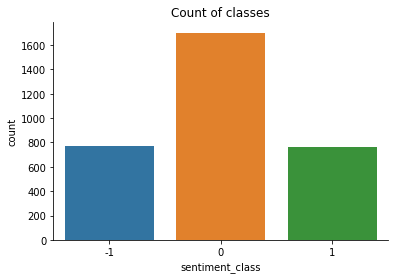

In [37]:
sns.countplot(train_df['sentiment_class']).set_title('Count of classes')
sns.despine()
plt.show()

This proves that we should use F1-score and cofusion matrix as out evaluation criteria rather than accuracy

In [38]:
""" Check for unique languages to check if ay translation is needed or not"""
unique_lang = train_df['lang'].unique()

print(unique_lang)

['en' '-0.0138325017' '-0.9677309496' '-0.3876905537' '0.5309553602'
 '-0.045423609' '0.1210638815' '&gt' ' have them delivered!'
 '-0.7860764746' ' very much loved\U0001f970️ …' '0.7885519508'
 '0.4310598662' '0.6034925894' '0.8837056921' '-0.4757848717'
 '0.1262837865' '0.8296402421' '0.2203775303' '-0.0320226838'
 '-0.0272467108' '-0.9022044897' 'I was ten weeks...' '0.4754834129' ' ️'
 '0.7120802873' '0.7493660991' '0.3716244571' '0.4616286043'
 '0.4479350131' ' PROSPERITY KING ZAY I MET YOU WHEN YOU WAS &amp'
 '0.6747864639' '-0.7798220898' '-0.6668237899' '-0.948781497'
 '-0.4189029043' '0.001710524' '0.0903948317' '-0.6936114103'
 '0.3087589587' " here's to !" '-0.7182082972' '0.195401415'
 '-0.0064143617' ' pink Peruvian opal! via' '0.8077853046' '0.5129957209'
 '-0.1651444775' '0.4611910293'
 ' look really confused 🤷\u200d️ i realize I’m ALWAYS like that!'
 '0.8531978334' " The Best Kids' Gardening Tools For Your Little Fa.."
 '0.8059809024' '0.7231463898' ' Find More' '0.8612

In [39]:
""" Check for unique languages to check if ay translation is needed or not"""
test_unique_lang = test_df['lang'].unique()

print(test_unique_lang)

['en' '0.4791830867'
 ' Cool Kids Mommy and Me Dress Mom Mum Kids Family Matching Tshirt Mother Daughter Son Clothes Family Look Outfits'
 '0.8951503903'
 'work hard are lessons taught thanks ️ the memories push me to do more &amp'
 '-0.0218696866' '-0.0637180928' '-0.3593259207' '0.8282736648'
 '0.2029243736' '0.1872451386' '0.2814340495' '-0.2284276553'
 '0.0939571057' ' pink Peruvian opal! via' '-0.0502434854' '0.0982439127'
 '0.5264386088' '0.114023937' '0.1496343926'
 ' defeated! ️ you! I wish I could you!' ' ️' ' Nutrition&gt'
 '0.8899117476' '0.7133047855' '-0.8241451498' '0.0576878645'
 '0.4952528915' '0.4579895335' '-0.3629539266' '-0.7368800504'
 '0.723328552' '0.2292727009' '-0.629744274' '0.5279802076' '0.3522749282'
 '-0.4706840537' 'Craig &ampad &amp' '0.0673621183' '-0.2670543086'
 ' others not as lucky!' '0.3496203775' '0.3085952048' '-0.8606603926'
 '-0.6367165569' '-0.8959314478' '0.1777219925' '0.1293615274'
 '0.9008097123' '0.8781107059' '-0.3424121055' '-0.38908094

In [40]:
""" Clearly, we can see that the language column seems to have a lot of mismatch data in both train and test data"""
def clean_lang(text):
    text = str(text)
    if text == 'en':
        return ''
    else:
        if text[0] == '-':
            text = text[1:]
        res = text.replace('.', '', 1).isdigit()
        # if it is a float number
        if res:
            return ''
        else:
            return text

In [41]:
train_df['clean_lang'] = train_df['lang'].apply(clean_lang)
train_df.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,clean_lang
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0,
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0,
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1,
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0,
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1,


In [42]:
test_df['clean_lang'] = test_df['lang'].apply(clean_lang)
test_df.head()

,id,original_text,lang,retweet_count,original_author,clean_lang
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood,
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii,
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg,
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters,
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg,


In [43]:
train_df['complete_text'] = train_df['original_text'] + train_df['clean_lang']
train_df.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,clean_lang,complete_text
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0,,Happy #MothersDay to all you amazing mothers o...
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0,,Happy Mothers Day Mum - I'm sorry I can't be t...
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1,,Happy mothers day To all This doing a mothers ...
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0,,Happy mothers day to this beautiful woman...ro...
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1,,Remembering the 3 most amazing ladies who made...


In [44]:
test_df['complete_text'] = test_df['original_text'] + test_df['clean_lang']
test_df.head()

,id,original_text,lang,retweet_count,original_author,clean_lang,complete_text
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood,,"3. Yeah, I once cooked potatoes when I was 3 y..."
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii,,"Happy Mother's Day to all the mums, step-mums,..."
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg,,"I love the people from the UK, however, when I..."
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters,,Happy 81st Birthday Happy Mother’s Day to my m...
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg,,Happy Mothers day to all those wonderful mothe...


In [45]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [46]:
# custom words to ignore
bad_words = ['www', 'https', 'instagram', 'igshid', 'us', 'twitter', 'com', 'pic']

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

In [47]:
stop_words = list(stopwords.words('english')) 
stop_words += bad_words
stop_words = set(stop_words)
def clean_text(text):
    new_string = text.lower()
    new_string = BeautifulSoup(new_string, "lxml").text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    new_string = re.sub('"','', new_string)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])    
    new_string = re.sub(r"'s\b","",new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string) 
    new_string = re.sub('[m]{2,}', 'mm', new_string)
    
    tokens = [w for w in new_string.split() if not w in stop_words]
   
    long_words=[]
    for i in tokens:
        if len(i)>1:                                              
            long_words.append(i)   
            
    return (" ".join(long_words)).strip()

In [48]:
train_clean_text = train_df['complete_text'].apply(clean_text)
train_clean_text[:5]

0    happy mothersday amazing mothers know hard abl...
1    happy mothers day mum sorry cannot bring mothe...
2    happy mothers day mothers days work today quie...
3    happy mothers day beautiful woman royalty soot...
4    remembering amazing ladies made late grandmoth...
Name: complete_text, dtype: object

In [49]:
df_clean_train_data = pd.DataFrame(columns = ['text', 'sentiment_class'])
df_clean_train_data['text'] = train_clean_text
df_clean_train_data['sentiment_class'] = train_df['sentiment_class']

df_clean_train_data.to_csv('Train_data_cleaned.csv', index = False)
df_clean_train_data.head()

,text,sentiment_class
0,happy mothersday amazing mothers know hard abl...,0
1,happy mothers day mum sorry cannot bring mothe...,0
2,happy mothers day mothers days work today quie...,-1
3,happy mothers day beautiful woman royalty soot...,0
4,remembering amazing ladies made late grandmoth...,-1


In [50]:
test_clean_text = test_df['complete_text'].apply(clean_text)
test_clean_text[:5]

0    yeah cooked potatoes years old mean threw bag ...
1    happy mother day mums step mums grandmothers d...
2    love people uk however awoke saw mothersday tr...
3    happy st birthday happy mother day mum see tod...
4    happy mothers day wonderful mothers world live...
Name: complete_text, dtype: object

In [51]:
df_clean_test_data = pd.DataFrame(columns = ['text'])
df_clean_test_data['text'] = test_clean_text
# df_clean_test_data['sentiment_class'] = train_df['sentiment_class']

df_clean_test_data.to_csv('Test_data_cleaned.csv', index = False)
df_clean_test_data.head()

,text
0,yeah cooked potatoes years old mean threw bag ...
1,happy mother day mums step mums grandmothers d...
2,love people uk however awoke saw mothersday tr...
3,happy st birthday happy mother day mum see tod...
4,happy mothers day wonderful mothers world live...


### Creating Graph Functions

In [52]:
def print_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, background_color='white', stopwords=set(stop_words)).generate(text)
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)

### Creating a vocabulary and Text analysis on train data

In [53]:
# joining all training text
train_text_joined = ' '.join(train_clean_text)
train_text_joined

'happy mothersday amazing mothers know hard able see mothers today protect vulnerable members society beatcoronavirus va nfjfq happy mothers day mum sorry cannot bring mothers day flowers cwtch honestly point would walk hot coals able bells soon love lots xxx photos app goo gl vxblrsczd te happy mothers day mothers days work today quiet time reflect dog walk finish jigsaw garden learn guitar chords drunk strawberry gin tonic watch lee evens dvd favourite place visit isolate gz xvvf happy mothers day beautiful woman royalty soothes mummy jeremy emerald prayforroksie ultimateloveng oeeti pvv remembering amazing ladies made late grandmother iris mum carol great grandmother ethel missed never forgotten happy mothers day great mums love sent xxxx xzzzdeybje happy mother day bratz world familiez yasmin mum bratz bratzworldfamiliez bratz bratzkidz bratzyasmin bratzportia theonlygirlswithapassionforfashion bratzdolls bratzcollector happymothersday mothersday mothersday azdoesmakeup zhpu happy 

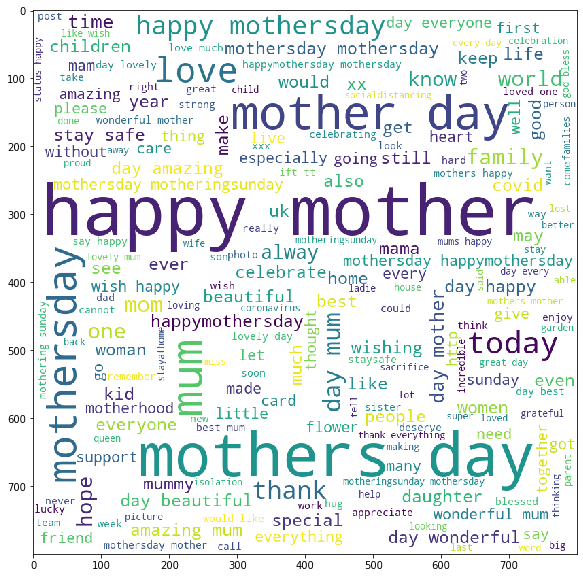

In [54]:
# printing the word clound
print_wordcloud(train_text_joined)

### Creating Vocabulary and Text analysis on test data

In [55]:
# joining all test text
test_text_joined = ' '.join(test_clean_text)
test_text_joined

'yeah cooked potatoes years old mean threw bag spuds toilet happy mothers day made breakfast time thought cool drawing naked lady dachshund overhead projector psychology class happy mother day mums step mums grandmothers dads cover parental roles mothersday motheringsunday soapandglory tatus love people uk however awoke saw mothersday trending woke american immediately happy mother day mums across way god bless love share sacrifices make happy st birthday happy mother day mum see today keep safe shame many others ignoring advice covid mothersday motheringsunday vsvmkmfptr happy mothers day wonderful mothers world live present always rely mother rock families whatever life throws happy mother day thanks support mother daughter spend rest lives unburdened tumours made every day feel like could last lent faith mothersday globalhealth thankyou cqszshrxjj happy sunday ruth happy mothers day lovely peaceful beautiful day beautiful friend stay super safe love hugs always ckq ijn happy mothers

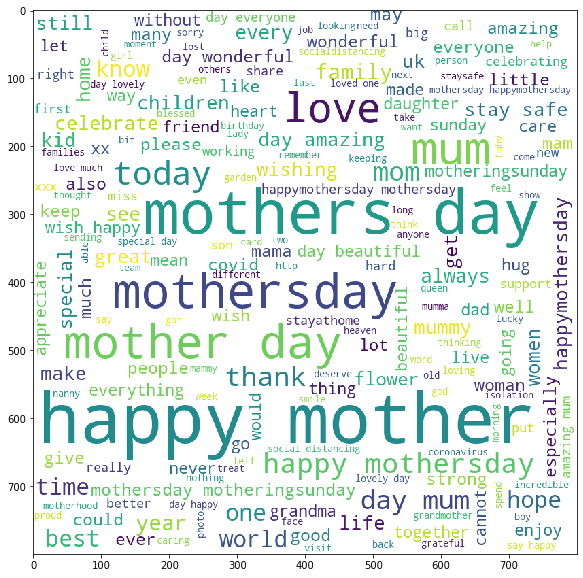

In [56]:
# printing the word clound
print_wordcloud(test_text_joined)

In [57]:
# finding most common words

train_freq = nltk.FreqDist(train_text_joined.split())
print('Most Common words in train data')
print(train_freq.most_common(20))

test_freq = nltk.FreqDist(test_text_joined.split())
print('\n\nMost Common words in test data')
print(test_freq.most_common(20))

Most Common words in train data
[('day', 3781), ('happy', 3455), ('mothers', 2825), ('mothersday', 1871), ('mother', 1688), ('mum', 1004), ('love', 935), ('mums', 704), ('today', 538), ('amazing', 337), ('hope', 300), ('happymothersday', 291), ('thank', 281), ('world', 273), ('wonderful', 258), ('one', 247), ('best', 230), ('beautiful', 227), ('know', 225), ('family', 218)]


Most Common words in test data
[('day', 1566), ('happy', 1450), ('mothers', 1141), ('mothersday', 781), ('mother', 740), ('love', 429), ('mum', 379), ('mums', 285), ('today', 239), ('amazing', 151), ('happymothersday', 127), ('hope', 124), ('thank', 121), ('best', 114), ('world', 112), ('safe', 111), ('stay', 111), ('know', 105), ('wonderful', 103), ('mom', 102)]


### N_gram analysis

In [58]:
# taking upto 4 grams for analysis
train_ngrams_dict = {}
test_ngrams_dict = {}
for i in range(1, 5):
    train_ngrams_dict[i] = [g for g in ngrams(train_text_joined.split(), n=i)]
    test_ngrams_dict[i] = [g for g in ngrams(test_text_joined.split(), n=i)]

In [59]:
train_ngram_counts = []
for i in train_ngrams_dict.keys():
    count_dict = {}
    for val in train_ngrams_dict[i]:
        if val in count_dict:
            count_dict[val] += 1
        else:
            count_dict[val] = 1
    sorted_count_dict = dict(sorted(count_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse = True))
    train_ngram_counts.append(sorted_count_dict)

In [60]:
test_ngram_counts = []
for i in test_ngrams_dict.keys():
    count_dict = {}
    for val in test_ngrams_dict[i]:
        if val in count_dict:
            count_dict[val] += 1
        else:
            count_dict[val] = 1
    sorted_count_dict = dict(sorted(count_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse = True))
    test_ngram_counts.append(sorted_count_dict)

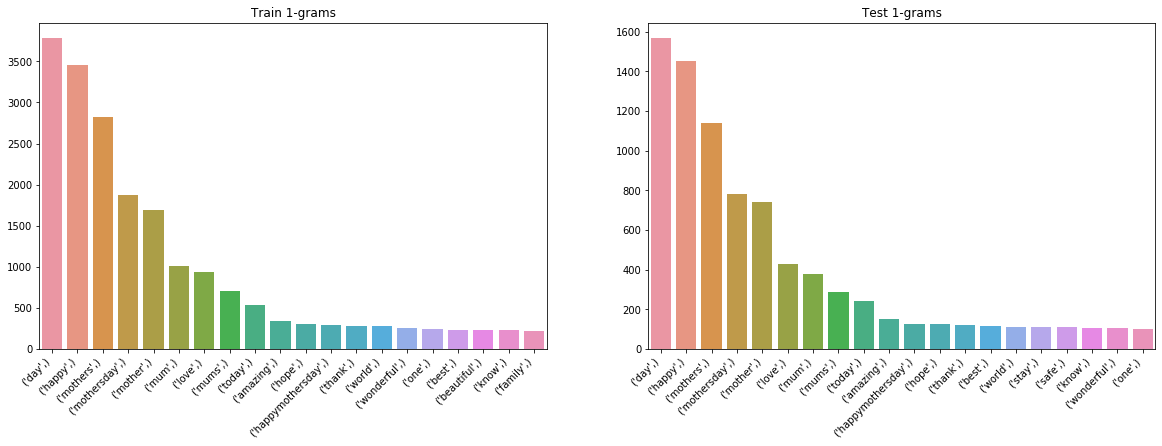

In [61]:
# 1-gram
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot([str(i) for i in list(train_ngram_counts[0].keys())[:20]], list(train_ngram_counts[0].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Train 1-grams')

plt.subplot(1, 2, 2)
ax = sns.barplot([str(i) for i in list(test_ngram_counts[0].keys())[:20]], list(test_ngram_counts[0].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Test 1-grams')

plt.show()

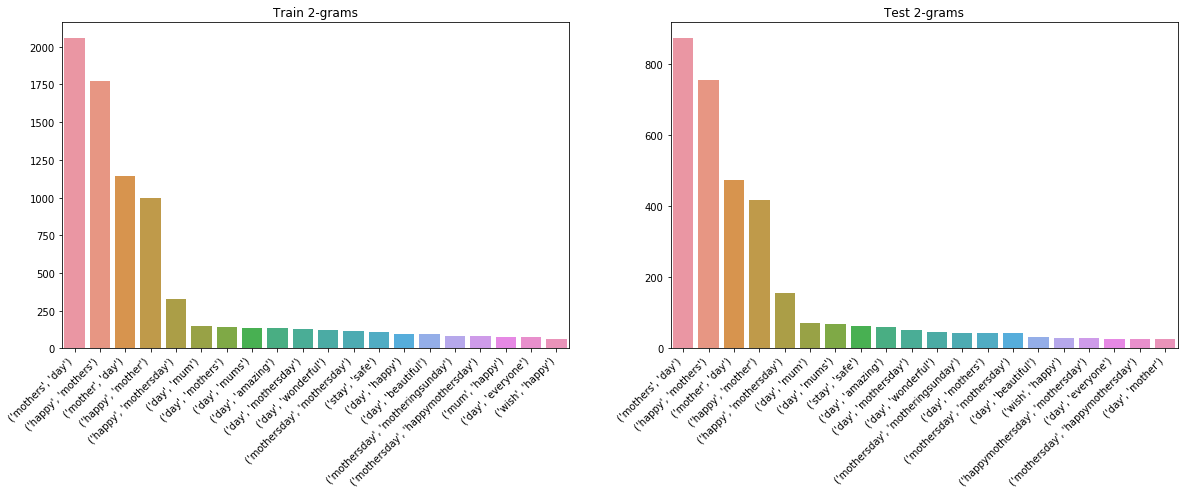

In [62]:
# 2-gram
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot([str(i) for i in list(train_ngram_counts[1].keys())[:20]], list(train_ngram_counts[1].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Train 2-grams')

plt.subplot(1, 2, 2)
ax = sns.barplot([str(i) for i in list(test_ngram_counts[1].keys())[:20]], list(test_ngram_counts[1].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Test 2-grams')

plt.show()

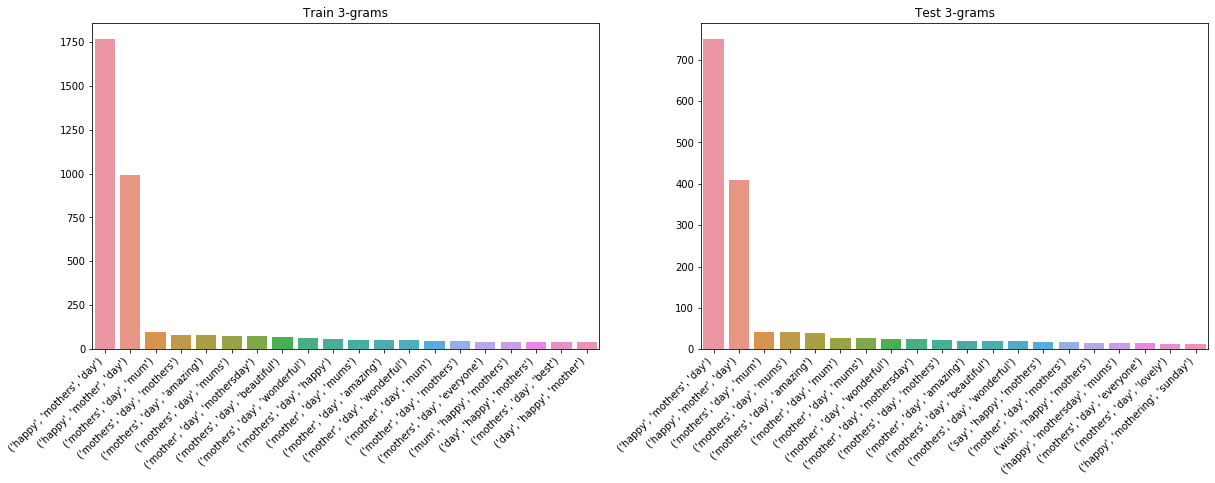

In [63]:
# 3-gram
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot([str(i) for i in list(train_ngram_counts[2].keys())[:20]], list(train_ngram_counts[2].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Train 3-grams')

plt.subplot(1, 2, 2)
ax = sns.barplot([str(i) for i in list(test_ngram_counts[2].keys())[:20]], list(test_ngram_counts[2].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Test 3-grams')

plt.show()

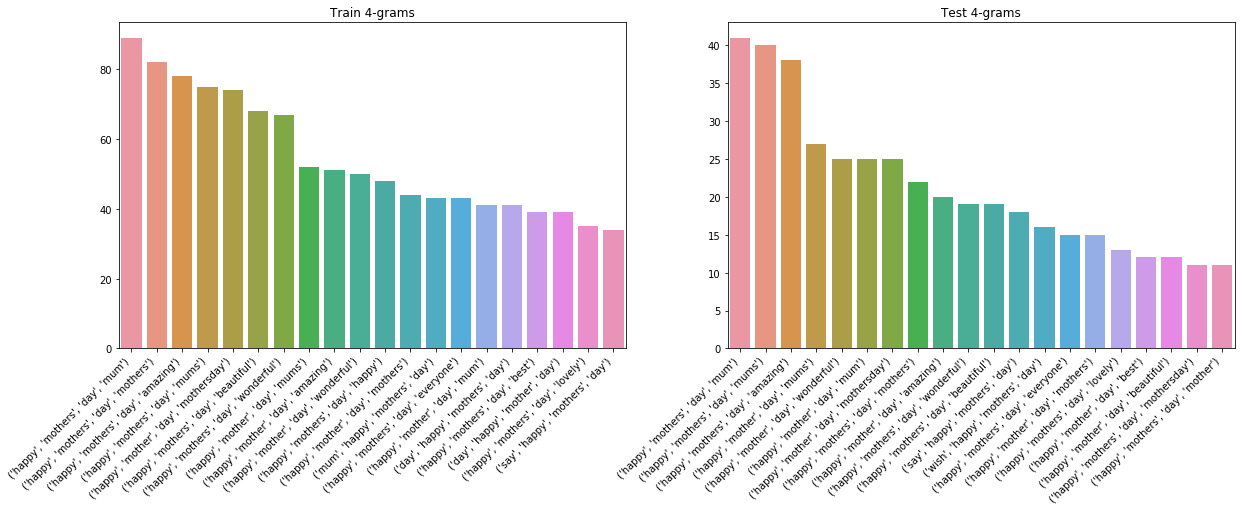

In [64]:
# 4-gram
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot([str(i) for i in list(train_ngram_counts[3].keys())[:20]], list(train_ngram_counts[3].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Train 4-grams')

plt.subplot(1, 2, 2)
ax = sns.barplot([str(i) for i in list(test_ngram_counts[3].keys())[:20]], list(test_ngram_counts[3].values())[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment = 'right')
plt.title('Test 4-grams')

plt.show()

## Sentiment Analysis

#### Let's first try out different algorithms on training data to see how well they perform 

1. TF-IDF Method 
2. Text Blob
3. Vader Lexicon
4. Neural Network Based Approach (TF + LSTM)
5. BERT Model

## Extracting Features using TF-IDF Method

In [65]:
# using Count Vectorization
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=500, stop_words='english')
bag_of_words = vectorizer.fit_transform(train_clean_text)
test_bag_of_words = vectorizer.transform(test_clean_text)
feature_names = vectorizer.get_feature_names()
df_bow = pd.DataFrame(bag_of_words.todense(), columns = feature_names)
test_df_bow = pd.DataFrame(test_bag_of_words.todense(), columns = feature_names)
df_bow.head()

,able,absolute,actually,admire,africa,afternoon,ago,amazing,amen,angel,...,xx,xxx,xxxx,ya,year,years,yesterday,young,youtu,youtube
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
test_df_bow.head()

,able,absolute,actually,admire,africa,afternoon,ago,amazing,amen,angel,...,xx,xxx,xxxx,ya,year,years,yesterday,young,youtu,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TF-IDF stands for Term Frequency-Inverse Document Frequency, and the TF-IDF weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

In [67]:
# applying TF_IDF
tf_idf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=500, stop_words='english')

bag_of_words = tf_idf_vectorizer.fit_transform(train_clean_text)
test_bag_of_words = tf_idf_vectorizer.transform(test_clean_text)

feature_names = tf_idf_vectorizer.get_feature_names()

df_tf_idf = pd.DataFrame(bag_of_words.todense(), columns = feature_names)
test_df_tf_idf = pd.DataFrame(test_bag_of_words.todense(), columns = feature_names)

df_tf_idf.head()

,able,absolute,actually,admire,africa,afternoon,ago,amazing,amen,angel,...,xx,xxx,xxxx,ya,year,years,yesterday,young,youtu,youtube
0,0.365980,0.0,0.0,0.0,0.0,0.0,0.0,0.254517,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.281812,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.288336,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.157582,0.0,0.0,...,0.0,0.000000,0.291061,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
test_df_tf_idf.head()

,able,absolute,actually,admire,africa,afternoon,ago,amazing,amen,angel,...,xx,xxx,xxxx,ya,year,years,yesterday,young,youtu,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.375775,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [69]:
# x_train_bow, x_val_bow, y_train_bow, y_val_bow = train_test_split(df_bow, train_df['sentiment_class'], 
#                                                                   test_size = 0.2, random_state = 1)


x_train_bow = df_bow
y_train_bow = train_df['sentiment_class']
x_test_bow = test_df_bow

x_train_bow.shape, x_test_bow.shape, y_train_bow.shape

((3235, 500), (1387, 500), (3235,))

In [70]:
# x_train_tf_idf, x_val_tf_idf, y_train_tf_idf, y_val_tf_idf = train_test_split(df_tf_idf, train_df['sentiment_class'], 
#                                                                   test_size = 0.2, random_state = 1)

x_train_tf_idf = df_tf_idf
y_train_tf_idf = train_df['sentiment_class']
x_test_tf_idf = test_df_tf_idf

x_train_tf_idf.shape, x_test_tf_idf.shape, y_train_tf_idf.shape

((3235, 500), (1387, 500), (3235,))

### Applying Machine Learnign Models on TF_IDF data
1. GradientBoosting Classifier

2. XGBoost

#### Gradient Boosting Classifier

In [252]:
# fitting gradient boosting classifier on bow

model_gbc_bow = GradientBoostingClassifier()
model_gbc_bow.fit(x_train_bow, y_train_bow)

model_gbc_bow_pred = model_gbc_bow.predict(x_val_bow)

model_gbc_bow_prob = model_gbc_bow.predict_proba(x_val_bow)

model_gbc_bow_acc_score = model_gbc_bow.score(x_val_bow, y_val_bow)

model_gbc_bow_f1_score = f1_score(model_gbc_bow_pred, y_val_bow, average='weighted')

print('Accuracy Score :', model_gbc_bow_acc_score)
print('F1 Score :', model_gbc_bow_f1_score)
print('Confusion Matrix: \n', confusion_matrix(model_gbc_bow_pred, y_val_tf_idf)) 

ValueError: Number of features of the model must match the input. Model n_features is 750 and input n_features is 1000 

In [71]:
## predicting on test data
model_gbc_bow = GradientBoostingClassifier()
model_gbc_bow.fit(x_train_bow, y_train_bow)

model_gbc_bow_pred = model_gbc_bow.predict(x_test_bow)
model_gbc_bow_prob = model_gbc_bow.predict_proba(x_test_bow)

In [ ]:
# fitting gradient boosting classifier on tf_idf

model_gbc_tf_idf = GradientBoostingClassifier()
model_gbc_tf_idf.fit(x_train_tf_idf, y_train_tf_idf)

model_gbc_tf_idf_pred = model_gbc_tf_idf.predict(x_val_tf_idf)

model_gbc_tf_idf_prob = model_gbc_tf_idf.predict_proba(x_val_tf_idf)

model_gbc_tf_idf_acc_score = model_gbc_tf_idf.score(x_val_tf_idf, y_val_tf_idf)

model_gbc_tf_idf_f1_score = f1_score(model_gbc_tf_idf_pred, y_val_tf_idf, average='weighted')

print('Accuracy Score :', model_gbc_tf_idf_acc_score)
print('F1 Score :', model_gbc_tf_idf_f1_score)
print('Confusion Matrix: \n', confusion_matrix(model_gbc_tf_idf_pred, y_val_tf_idf)) 
print('Classification Report: \n', classification_report(model_gbc_tf_idf_pred, y_val_tf_idf)) 

In [72]:
model_gbc_tf_idf = GradientBoostingClassifier()
model_gbc_tf_idf.fit(x_train_tf_idf, y_train_tf_idf)

model_gbc_tf_idf_pred = model_gbc_tf_idf.predict(x_test_tf_idf)

model_gbc_tf_idf_prob = model_gbc_tf_idf.predict_proba(x_test_tf_idf)

In [73]:
len(model_gbc_tf_idf_pred), test_df.shape

(1387, (1387, 7))

In [ ]:
test_df_copy = test_df.copy()
test_df_copy['GBC BOW Sentiment Score'] = model_gbc_bow_pred
test_df_copy.drop(['original_text', 'lang', 'retweet_count', 'original_author', 'clean_lang', 'complete_text'], 
                  axis = 1, inplace = True)
test_df_copy.head()

In [273]:
test_df_copy2 = test_df.copy()
test_df_copy2['GBC TF-IDF Sentiment Score'] = model_gbc_tf_idf_pred
test_df_copy2.drop(['original_text', 'lang', 'retweet_count', 'original_author', 'clean_lang', 'complete_text'], 
                  axis = 1, inplace = True)
test_df_copy2.head()

,id,GBC TF-IDF Sentiment Score
0,1.246628e+18,1
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,0


In [274]:
test_df_copy.to_csv('GBC BOW 3.csv', index = False)
test_df_copy2.to_csv('GBC TF-IDF 3.csv', index = False)

In [275]:
df_submission = test_df.copy()
df_submission['sentiment_class'] = model_gbc_tf_idf_pred
df_submission.drop(['original_text', 'lang', 'retweet_count', 'original_author', 'clean_lang', 'complete_text'], 
                  axis = 1, inplace = True)
df_submission.to_csv('Submission3.csv', index = False)
df_submission.head()

,id,sentiment_class
0,1.246628e+18,1
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,0


#### XGBoost

In [192]:
# fitting XGBoost on bow

model_xgboost_bow = XGBClassifier(learning_rate=0.9)

model_xgboost_bow.fit(x_train_bow, y_train_bow)

model_xgboost_bow_pred = model_xgboost_bow.predict(x_val_bow)

model_xgboost_bow_prob = model_xgboost_bow.predict_proba(x_val_bow)

model_xgboost_bow_acc_score = model_xgboost_bow.score(x_val_bow, y_val_bow)

model_xgboost_bow_f1_score = f1_score(model_xgboost_bow_pred, y_val_bow, average='weighted')

print('Accuracy Score :', model_xgboost_bow_acc_score)
print('F1 Score :', model_xgboost_bow_f1_score)
print('Confusion Matrix: \n', confusion_matrix(model_xgboost_bow_pred, y_val_tf_idf))

Accuracy Score : 0.46986089644513135
F1 Score : 0.529972560263153
Confusion Matrix: 
 [[ 20  36  18]
 [123 261 118]
 [ 18  30  23]]


In [194]:
# fitting XGBoost on TF_IDF 

model_xgboost_tf_idf = XGBClassifier(learning_rate=0.9)

model_xgboost_tf_idf.fit(x_train_tf_idf, y_train_tf_idf)

model_xgboost_tf_idf_pred = model_xgboost_tf_idf.predict(x_val_tf_idf)
model_xgboost_tf_idf_prob = model_xgboost_tf_idf.predict_proba(x_val_tf_idf)

model_xgboost_tf_idf_acc_score = model_xgboost_tf_idf.score(x_val_tf_idf, y_val_tf_idf)

model_xgboost_tf_idf_f1_score = f1_score(model_xgboost_tf_idf_pred, y_val_tf_idf, average='weighted')

print('Accuracy Score :', model_xgboost_tf_idf_acc_score)
print('F1 Score :', model_xgboost_tf_idf_f1_score)
print('Confusion Matrix: \n', confusion_matrix(model_xgboost_tf_idf_pred, y_val_tf_idf)) 
print('Classification Report: \n', classification_report(model_xgboost_tf_idf_pred, y_val_tf_idf)) 

Accuracy Score : 0.43431221020092736
F1 Score : 0.4848190017150474
Confusion Matrix: 
 [[ 18  46  28]
 [122 242 110]
 [ 21  39  21]]
Classification Report: 
               precision    recall  f1-score   support

          -1       0.11      0.20      0.14        92
           0       0.74      0.51      0.60       474
           1       0.13      0.26      0.17        81

   micro avg       0.43      0.43      0.43       647
   macro avg       0.33      0.32      0.31       647
weighted avg       0.57      0.43      0.48       647



In [203]:
check_gbc = pd.DataFrame()
check_gbc['prob_neg'] = model_gbc_tf_idf_prob[:, 0]
check_gbc['prob_neutral'] = model_gbc_tf_idf_prob[:, 1]
check_gbc['prob_positive'] = model_gbc_tf_idf_prob[:, 2]
check_gbc['Sentiment Pred'] = model_gbc_tf_idf_pred
check_gbc['Sentiment org'] = list(y_val_tf_idf)
check_gbc.head()

,prob_neg,prob_neutral,prob_positive,Sentiment Pred,Sentiment org
0,0.228948,0.550153,0.220899,0,1
1,0.220245,0.461771,0.317985,0,0
2,0.278380,0.569777,0.151843,0,0
3,0.328187,0.345408,0.326405,0,1
4,0.226402,0.543165,0.230433,0,0


## Vader Lexicon

In [74]:
x_train_data = train_clean_text
y_train_data = train_df['sentiment_class']

x_test_data = test_clean_text

len(train_clean_text), len(y_train_data), len(x_test_data)

(3235, 3235, 1387)

In [75]:
def sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_dict = sia.polarity_scores(text)
    
    max_val = max(sentiment_dict['neg'], max(sentiment_dict['pos'], sentiment_dict['neu']))
    sc = 0

    for key in sentiment_dict.keys():
        
        if sentiment_dict[key] == max_val:
            if key.strip() == 'neg':
                sc = -1
            elif key.strip() == 'neu':
                sc = 0
            else:
                sc = 1
            return sentiment_dict, sc

In [76]:
train_neg_score = []
train_neu_score = []
train_pos_score = []
train_compound_score = []
train_sentiment_class = []

for text in x_train_data:
    sent_dict, sent_class = sentiment_score(text)
    train_neg_score.append(sent_dict['neg'])
    train_neu_score.append(sent_dict['neu'])
    train_pos_score.append(sent_dict['pos'])
    train_compound_score.append(sent_dict['compound'])
    train_sentiment_class.append(sent_class)
    
train_vader_df = pd.DataFrame(columns = ['text', 'neg', 'neu', 'pos', 'compound', 'sent_class'])
train_vader_df['text'] = x_train_data
train_vader_df['neg'] = train_neg_score
train_vader_df['neu'] = train_neu_score
train_vader_df['pos'] = train_pos_score
train_vader_df['compound'] = train_compound_score
train_vader_df['sent_class'] = train_sentiment_class

train_vader_df.head()

,text,neg,neu,pos,compound,sent_class
0,happy mothersday amazing mothers know hard abl...,0.130,0.472,0.398,0.8316,0
1,happy mothers day mum sorry cannot bring mothe...,0.034,0.623,0.343,0.9169,0
2,happy mothers day mothers days work today quie...,0.114,0.786,0.100,0.1280,0
3,happy mothers day beautiful woman royalty soot...,0.000,0.612,0.388,0.8225,0
4,remembering amazing ladies made late grandmoth...,0.130,0.424,0.446,0.9283,1


In [77]:
vader_train_f1Score = f1_score(y_train_data, train_sentiment_class, average='weighted')
print('Vader train f1 score :', vader_train_f1Score)
print()
print('Confusion matrix : \n', confusion_matrix(y_train_data, train_sentiment_class))
print()
print('Classification Report\n', classification_report(y_train_data, train_sentiment_class))

Vader train f1 score : 0.3864116128305146

Confusion matrix : 
 [[   1  522  246]
 [   3 1200  498]
 [   0  521  244]]

Classification Report
               precision    recall  f1-score   support

          -1       0.25      0.00      0.00       769
           0       0.53      0.71      0.61      1701
           1       0.25      0.32      0.28       765

   micro avg       0.45      0.45      0.45      3235
   macro avg       0.34      0.34      0.30      3235
weighted avg       0.40      0.45      0.39      3235



In [78]:
test_neg_score = []
test_neu_score = []
test_pos_score = []
test_compound_score = []
test_sentiment_class = []

for text in x_test_data:
    sent_dict, sent_class = sentiment_score(text)
    test_neg_score.append(sent_dict['neg'])
    test_neu_score.append(sent_dict['neu'])
    test_pos_score.append(sent_dict['pos'])
    test_compound_score.append(sent_dict['compound'])
    test_sentiment_class.append(sent_class)
    
test_vader_df = pd.DataFrame(columns = ['text', 'neg', 'neu', 'pos', 'compound', 'sent_class'])
test_vader_df['text'] = x_test_data
test_vader_df['neg'] = test_neg_score
test_vader_df['neu'] = test_neu_score
test_vader_df['pos'] = test_pos_score
test_vader_df['compound'] = test_compound_score
test_vader_df['sent_class'] = test_sentiment_class

test_vader_df.head()

,text,neg,neu,pos,compound,sent_class
0,yeah cooked potatoes years old mean threw bag ...,0.000,0.737,0.263,0.8020,0
1,happy mother day mums step mums grandmothers d...,0.000,0.791,0.209,0.5719,0
2,love people uk however awoke saw mothersday tr...,0.000,0.470,0.530,0.9595,1
3,happy st birthday happy mother day mum see tod...,0.186,0.482,0.331,0.6705,0
4,happy mothers day wonderful mothers world live...,0.000,0.654,0.346,0.8126,0


In [101]:
test_vader_df.to_csv('Vader Sentiment.csv', index = False)

In [102]:
df_submission = test_df.copy()
df_submission['sentiment_class'] = test_sentiment_class
df_submission.drop(['original_text', 'lang', 'retweet_count', 'original_author', 'clean_lang', 'complete_text'], 
                  axis = 1, inplace = True)
df_submission.to_csv('Submission4.csv', index = False)
df_submission.head()

,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,0
2,1.244717e+18,1
3,1.245730e+18,0
4,1.244636e+18,0


## Ensembling Gradient Boosting and Vader Lexicon

In [81]:
gbc_prob = model_gbc_tf_idf_prob
gbc_prob.shape, gbc_prob

((1387, 3),
 array([[0.36243048, 0.28574256, 0.35182696],
        [0.23775806, 0.53530668, 0.22693526],
        [0.24246762, 0.52610195, 0.23143044],
        ...,
        [0.26617902, 0.52735738, 0.20646361],
        [0.22871458, 0.54761182, 0.2236736 ],
        [0.18853343, 0.58867194, 0.22279462]]))

In [82]:
vader_prob = np.array((test_neg_score, test_neu_score, test_pos_score)).T
vader_prob.shape, vader_prob

((1387, 3),
 array([[0.   , 0.737, 0.263],
        [0.   , 0.791, 0.209],
        [0.   , 0.47 , 0.53 ],
        ...,
        [0.   , 0.747, 0.253],
        [0.   , 0.636, 0.364],
        [0.104, 0.764, 0.132]]))

In [83]:
ensembled_prob = 0.6 * gbc_prob + 0.4 * vader_prob
ensembled_prob.shape, ensembled_prob

((1387, 3),
 array([[0.21745829, 0.46624554, 0.31629617],
        [0.14265484, 0.63758401, 0.21976116],
        [0.14548057, 0.50366117, 0.35085826],
        ...,
        [0.15970741, 0.61521443, 0.22507816],
        [0.13722875, 0.58296709, 0.27980416],
        [0.15472006, 0.65880317, 0.18647677]]))

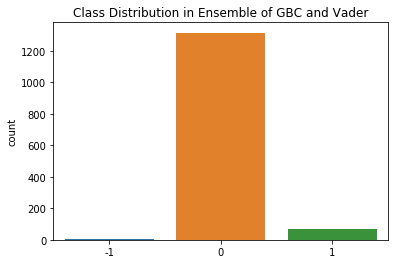

(array([-1,  0,  1], dtype=int64), array([   5, 1316,   66], dtype=int64))

In [84]:
ensembled_sent_class = [np.argmax(i)-1 for i in ensembled_prob]
sns.countplot(ensembled_sent_class).set_title('Class Distribution in Ensemble of GBC and Vader')
plt.show()
np.unique(ensembled_sent_class, return_counts=True)

In [85]:
df_submission = test_df.copy()
df_submission['sentiment_class'] = ensembled_sent_class
df_submission.drop(['original_text', 'lang', 'retweet_count', 'original_author', 'clean_lang', 'complete_text'], 
                  axis = 1, inplace = True)
df_submission.to_csv('Submission40.csv', index = False)
df_submission.head()

,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,0


In [121]:
df_submission = test_df.copy()
df_submission['sentiment_class'] = 0
df_submission.drop(['original_text', 'lang', 'retweet_count', 'original_author', 'clean_lang', 'complete_text'], 
                  axis = 1, inplace = True)
df_submission.to_csv('Fake_Submission.csv', index = False)
df_submission.head()

,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,0


Index(['lol'], dtype='object')
 0    1117
-1     147
 1     123
Name: sentiment_class, dtype: int64


,sentiment_class
0,1
1,0
2,0
3,0
4,1


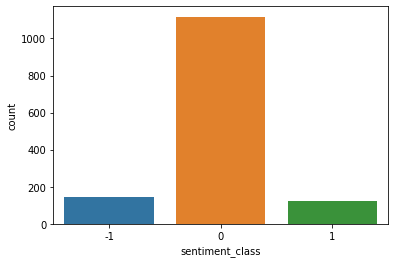

In [17]:
fake = pd.read_csv('fake.csv')
print(fake.columns)
fake.columns = ['sentiment_class']
sns.countplot(fake['sentiment_class'])
print(fake['sentiment_class'].value_counts())
fake.head()

In [18]:
test_df.columns

Index(['id', 'original_text', 'lang', 'retweet_count', 'original_author'], dtype='object')

In [19]:
df_submission = test_df.copy()
df_submission['sentiment_class'] = fake['sentiment_class']
df_submission.drop(['original_text', 'lang', 'retweet_count', 'original_author'], 
                  axis = 1, inplace = True)
df_submission.to_csv('checking model for submissions.csv', index = False)
df_submission.head()

,id,sentiment_class
0,1.246628e+18,1
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,1
